### Código do Modelo Random Forest Classifier

In [1]:
import pandas as pd
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#conectando ao banco de dados
conn = psycopg2.connect(dbname="dfo2vqe9hs2knm", 
                        user="zgbodaynfjorzt",
                        password="d2b11c0c6039df67f39d22f680fb92a843a1b652e3d5b692f6670c0a2abc2804", 
                        host='ec2-3-222-74-92.compute-1.amazonaws.com', 
                        port='5432')

In [3]:
sql1 = "select * from forms"
sql2 = "select * from order_items"
sql3 = "select * from orders"

In [4]:
data1 = pd.read_sql_query(sql1, conn)
data2 = pd.read_sql_query(sql2, conn)
data3 = pd.read_sql_query(sql3, conn)
conn = None

In [5]:
data1.head()

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,...,tipo_fios,procedimentos,tempo_procedimento,dieta,atividade_fisica,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente,Nunca,Característica 1,25 a 34,Efeito 7,Rosas
1,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO,7,...,Perfeitos,Todos acima,Há mais de 1 mês,Nenhuma restrição,Nunca,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto
2,d101fc0075dac29db1168cfc61ad44,c3344fad450ee424700d,2022-01-04 19:34:05,Android,Chrome,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,2,...,Rebeldes,Todos acima,Há mais de 1 mês,Nenhuma restrição,Raramente,Regularmente,Característica 7,2 a 10,Efeito 7,Rosas
3,0957fb9d7be36b4d079b6582bb6785,8105e34124e90300d8b5,2022-01-05 18:29:41,Android,Chrome,"Manchester, England",BR,MANCHESTER,ENGLAND,5,...,Rebeldes,Todos acima,Há mais de 1 mês,Celíaca,Raramente,Regularmente,Característica 7,25 a 34,Efeito 7,Rosas
4,ba73bdcc6c063ab08b533eae5505eb,636382f3f545eec3fe97,2022-01-07 11:44:31,Android,Chrome,"Tijucas, Santa Catarina",BR,TIJUCAS,SANTA CATARINA,4,...,Rebeldes,Tintura,Há 1 semana,Celíaca,Sempre,Nunca,Característica 10,18 a 24,Efeito 7,Eucalipto


In [6]:
#limpeza dos dados
data1.drop(['localizacao','navegador','utm_source'], axis = 1, inplace = True)

In [7]:
data1['cidade'] = data1['cidade'].replace(np.NaN, 0)

In [8]:
cidade_0  = data1[data1.cidade == 0]


In [9]:
data1['estado'] = data1['estado'].replace(' NULL', 0)

In [10]:
estado_0 = data1[data1.estado == 0]


In [11]:
data1 = data1.drop(index = estado_0.index)

In [12]:
data1['estado'] = data1['estado'].replace(np.NaN, 0)
estado_0 = data1[data1.estado == 0]

In [13]:
data1 = data1.drop(index = estado_0.index)

In [14]:
data1.drop(['locale'], axis = 1, inplace = True)

In [15]:
#criando uma coluna de dia da semana
data1['dia_semana'] = data1['data'].dt.day_name()

In [16]:
#agrupando os estados fora do brasil + Amapa
df_tipo_estado = data1.estado.value_counts()
colunas_agrupar = []

for tipo in df_tipo_estado.index:
    if df_tipo_estado[tipo] < 400:
        colunas_agrupar.append(tipo)

In [17]:
#dos estados brasileiro, somente Roraima entrou como outros
for tipo in colunas_agrupar:
    data1.loc[data1['estado']==tipo, 'estado'] = 'Outros'

In [18]:
#apagando os dados nulos de efeitos_desejados
data1.dropna(subset = ['efeitos_desejados'], inplace = True)

In [19]:
#avaliar a quantidade de efeitos_desejados
data1['num_efeitos_desejados'] = data1.efeitos_desejados.str.split(',').apply(len)

In [20]:
# repetindo o processo para numero_caracteristica e numero_procedimentos
data1['num_caracteristica'] = data1.caracteristica.str.split(',').apply(len)
data1['num_procedimentos'] = data1.procedimentos.str.split(',').apply(len)

In [21]:
#apagando as colunas 'efeitos_desejados','caracteristica','procedimentos'
data1 = data1.drop(['efeitos_desejados','caracteristica','procedimentos'], axis = 1)

### Combinando os DF

In [22]:
#criando uma coluna target no DF de fechamento das compras
data3['target'] = 1

In [23]:
#preparando o data2 - criar um data4 para fazer a combinação
data4 = data2.drop(['id','id_produto','qtde','valor'], axis = 1)

In [24]:
#id_pedido
#data 3 left - parâmetro inner, on id_pedido, 
data5 = pd.merge(
    left = data3,
    right = data4,
    on = 'id_pedido',    
)

In [25]:
data6 = data5[['id_form', 'target']]

In [26]:
data7 = pd.merge(
    left = data1,
    right = data6,
    how = 'left',
    on = 'id_form'
    
)

In [27]:
data7['target'] = data7['target'].replace(np.NaN, 0)

In [28]:
dados = data7.drop(['id_form', 'id_cliente', 'data', 'cidade'], axis = 1)

### Pre processamento dos dados

In [29]:
X_cat = dados[['estado', 'tipo_cabelo',
       'comprimento', 'tipo_fios', 'tempo_procedimento', 'dieta',
       'atividade_fisica', 'frequencia_estresse', 'faixa_etaria', 'fragancia']]
#removendo o sistema operacional: não influencia no resultado

In [30]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(X_cat)

enc.categories_

X_categ = enc.transform(X_cat).toarray()

In [31]:
X_encoder = pd.DataFrame(X_categ, columns = enc.get_feature_names_out(X_cat.columns))

In [32]:
X_numerico = dados[['qtde_lavagem_semana', 'num_efeitos_desejados',
       'num_caracteristica','num_procedimentos']]

In [33]:
X_df = pd.concat([X_encoder, X_numerico], axis = 1)

In [34]:
y = dados.target

In [35]:
#normalizando os dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X_df)

In [36]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state = SEED)

In [38]:
#importando as métricas
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
#importando a matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
#importando a Curva ROC e AOC
from sklearn.metrics import roc_curve, roc_auc_score

Acurácia: 0.918
Precisão: 0.869
Recall: 0.911
F1: 0.912
------------------------------------------------------------------------------------------------------------------------


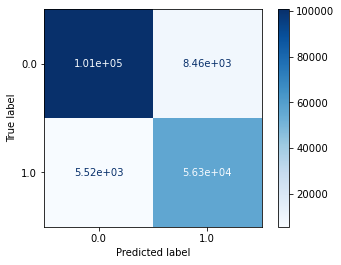

roc_auc: 0.953


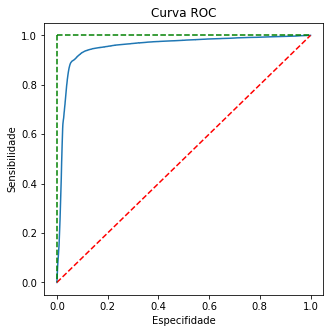

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94    109222
         1.0       0.87      0.91      0.89     61823

    accuracy                           0.92    171045
   macro avg       0.91      0.92      0.91    171045
weighted avg       0.92      0.92      0.92    171045



In [39]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier()

model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

print("Acurácia: {:.3}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precisão: {:.3}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {:.3}".format(metrics.recall_score(y_test, y_pred))) 
print("F1: {:.3}".format(metrics.f1_score(y_test, y_pred, average='macro')))
print('--'*60)

    
cm = plot_confusion_matrix(model1, X_test, y_test, cmap='Blues', values_format = '.3g')
plt.show()
    
prob_previsao = model1.predict_proba(X_test)[:,1] #probabilidade do evento ser predito como 0 ou 1 - uma matriz com 2 colunas

    #tfp = taxa falsos positivos
    #tvp = taxa verdadeiros positivos

tfp, tvp, limite = roc_curve(y_test, prob_previsao)
print('roc_auc: {:.3}'.format(roc_auc_score(y_test, prob_previsao)))

plt.subplots(1, figsize=(5,5))
plt.title('Curva ROC')
plt.plot(tfp,tvp)
plt.xlabel('Especifidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls="--", c = 'red') #plotando linha guia pontilhada vermelha
plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green') #plotando linha guia pontilhada verde
plt.show()

print(classification_report(y_test, y_pred))

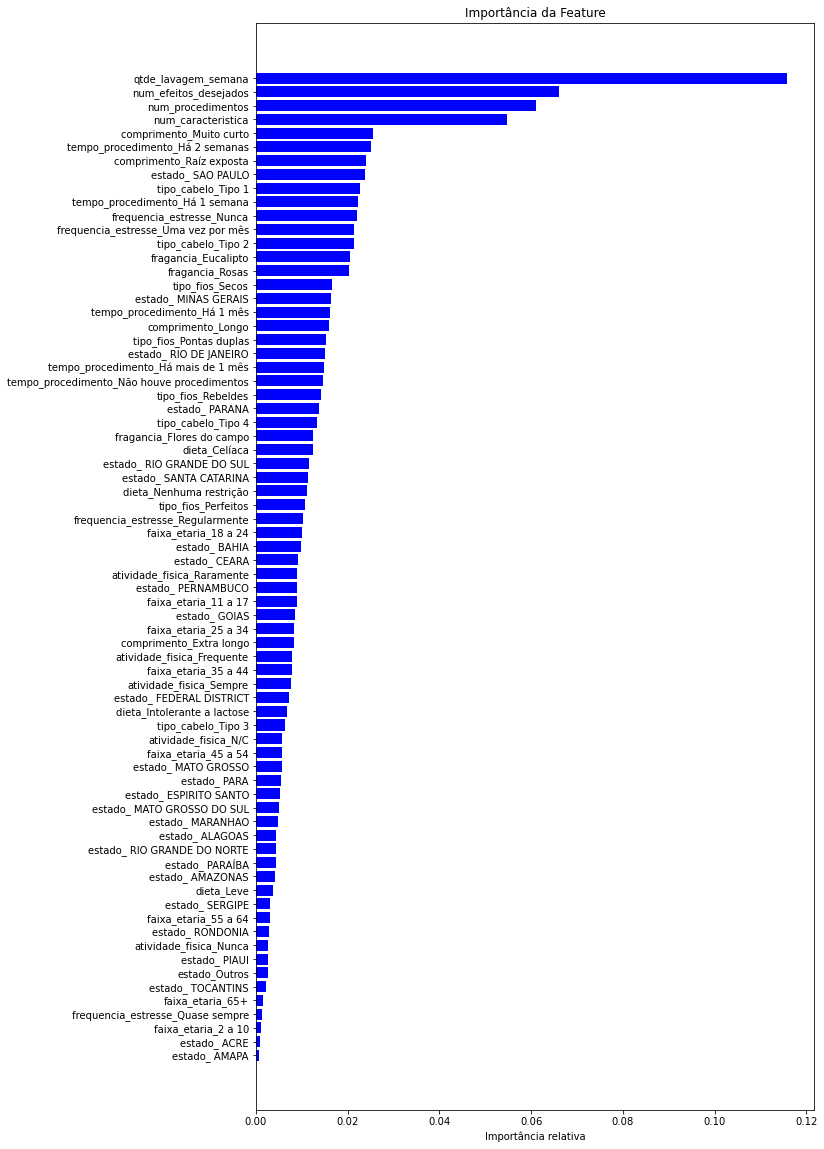

In [40]:
features = X_df.columns
importancia = model1.feature_importances_
indices = np.argsort(importancia)

ax = plt.figure(figsize=(10,20))
plt.title('Importância da Feature')
plt.barh(range(len(indices)), importancia[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importância relativa')
plt.show()

In [41]:
#cross validate do modelo

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(model1, X, y, cv=cv)

array([0.91979888, 0.9174837 , 0.92032506, 0.91861791, 0.91736677])

### Salvando o classificador

In [42]:
import pickle

In [43]:
with open('modeloRFC.pkl', 'wb') as f:
    pickle.dump([scaler, enc, model1], f)

In [44]:
with open('modeloRFC.pkl', 'rb') as f:
    min_max, encoder, model = pickle.load(f)

In [64]:
#teste com o primeiro registro da base de dados
X_novo = dados.iloc[0:1]
X_novo

,sistema_operacional,estado,qtde_lavagem_semana,tipo_cabelo,comprimento,tipo_fios,tempo_procedimento,dieta,atividade_fisica,frequencia_estresse,faixa_etaria,fragancia,dia_semana,num_efeitos_desejados,num_caracteristica,num_procedimentos,target
0,iOS,SAO PAULO,4,Tipo 2,Raíz exposta,Pontas duplas,Há 2 semanas,Celíaca,Frequente,Nunca,25 a 34,Rosas,Monday,1,1,1,1.0


In [65]:
#selecionando somente os atributos categóricos
X_cat_novo = X_novo[['estado', 'tipo_cabelo',
       'comprimento', 'tipo_fios', 'tempo_procedimento', 'dieta',
       'atividade_fisica', 'frequencia_estresse', 'faixa_etaria', 'fragancia']]

In [66]:
X_cat_novo = encoder.transform(X_cat_novo).toarray()

In [67]:
X_encoder_novo = pd.DataFrame(X_cat_novo, columns = enc.get_feature_names_out(X_cat.columns))


In [68]:
#selecionando os atributos numéricos
X_numerical_novo = X_novo[['qtde_lavagem_semana', 'num_efeitos_desejados',
       'num_caracteristica','num_procedimentos']]

In [69]:
#concatenando os dados categoricos e numericos
X_all_novo = pd.concat([X_encoder_novo, X_numerical_novo], axis = 1)


In [70]:
X_all_novo

,estado_ ACRE,estado_ ALAGOAS,estado_ AMAPA,estado_ AMAZONAS,estado_ BAHIA,estado_ CEARA,estado_ ESPIRITO SANTO,estado_ FEDERAL DISTRICT,estado_ GOIAS,estado_ MARANHAO,...,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+,fragancia_Eucalipto,fragancia_Flores do campo,fragancia_Rosas,qtde_lavagem_semana,num_efeitos_desejados,num_caracteristica,num_procedimentos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4,1,1,1


In [71]:
X_novo = min_max.transform(X_all_novo)


In [72]:
#Predição da random forest - mostrar a classe
model.predict(X_novo)

array([1.])

In [73]:
#probabilidade
model.predict_proba(X_novo)

array([[0.02, 0.98]])

In [74]:
#indice (classe 0 e classe 1)
model.classes_

array([0., 1.])